<a href="https://colab.research.google.com/github/Proskahn/Blood-Cell-Cancer-recognition-with-ResNet50/blob/main/classifiction_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
!pip install opendatasets
import opendatasets as od
import os
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
from torchvision import datasets, models, transforms

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


import the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
od.download('https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zhuangkang
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [00:18<00:00, 95.9MB/s]


Count the number of each set(data augmentation and normalization)

Here we need the skimage, sklearn.model_selection

In [42]:
import random
from skimage import io, transform, color, exposure
from skimage import data, img_as_float, img_as_ubyte
from imutils import paths
from sklearn.model_selection import train_test_split

data_dir  = '/content/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('number of testing list -:',len(test_list))
print('number of training list-:',len(train_list))

number of testing list -: 325
number of training list-: 2917


Here we use the function 'path.list_images'

In [43]:
print('Number of samples in dataset:',len(list(paths.list_images("/content/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"))))

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images("/content/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images("/content/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images("/content/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images("/content/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pro-B"))))

Number of samples in dataset: 3242
Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


resize the image(only the training data should be prepared)

In [46]:
import cv2 as cv
p=0
for img in test_list[:]:
  i=cv.imread(img)
  i=cv.resize(i,(224,224))
  label=img.split(os.path.sep)[4]
  if (label=="Benign"):
    b= ('/content/drive/MyDrive/Prepared_test/Benign/Benign'+str(p)+'.png')
  if (label=="[Malignant] Pre-B"):
    b= ('/content/drive/MyDrive/Prepared_test/Malignant Pre-B/Malignant Pre-B'+str(p)+'.png')
  if (label=="[Malignant] Pro-B"):
    b= ('/content/drive/MyDrive/Prepared_test/Malignant Pro-B/Malignant Pro-B'+str(p)+'.png')
  if (label=="[Malignant] early Pre-B"):
    b= ('/content/drive/MyDrive/Prepared_test/Malignant early Pre-B/Malignant early Pre-B'+str(p)+'.png')
  p=p+1
  cv.imwrite(b,i)



In [47]:
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from skimage import morphology
p=0

for img in train_list[:]:

    i= cv.imread(img)
    i= cv.resize(i,(224,224))
    label= img.split(os.path.sep)[4]

    if (label=="Benign"):
        b= ('/content/drive/MyDrive/Prepareddata/Benign/Benign'+str(p)+'.png')
    if (label=="[Malignant] Pre-B"):
        b= ('/content/drive/MyDrive/Prepareddata/Malignant Pre-B/Malignant Pre-B'+str(p)+'.png')
    if (label=="[Malignant] Pro-B"):
        b= ('/content/drive/MyDrive/Prepareddata/Malignant Pro-B/Malignant Pro-B'+str(p)+'.png')
    if (label=="[Malignant] early Pre-B"):
        b= ('/content/drive/MyDrive/Prepareddata/Malignant early Pre-B/Malignant early Pre-B'+str(p)+'.png')
    p+=1
    cv.imwrite(b,i)
    i= cv.cvtColor(i, cv.COLOR_BGR2RGB)
    i_lab = cv.cvtColor(i, cv.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv.split(i_lab)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0,n_init=10).fit(i2)  #Clustring
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv.threshold(ic,141,255 ,cv.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)
    out = cv.bitwise_and(i, i, mask=m2)
    if (label=="Benign"):
        b= ('/content/drive/MyDrive/Prepareddata/Benign/Benign'+str(p)+'.png')
    if (label=="[Malignant] Pre-B"):
        b= ('/content/drive/MyDrive/Prepareddata/Malignant Pre-B/Malignant Pre-B'+str(p)+'.png')
    if (label=="[Malignant] Pro-B"):
        b= ('/content/drive/MyDrive/Prepareddata/Malignant Pro-B/Malignant Pro-B'+str(p)+'.png')
    if (label=="[Malignant] early Pre-B"):
        b= ('/content/drive/MyDrive/Prepareddata/Malignant early Pre-B/Malignant early Pre-B'+str(p)+'.png')
    p+=1
    out= cv.cvtColor(out, cv.COLOR_RGB2BGR)
    cv.imwrite(b,out)



produce the train generator

In [45]:
# import shutil
# shutil.rmtree('/content/drive/MyDrive/Prepared_test')

In [49]:
prepared_data_path = '/content/drive/MyDrive/Prepared_test'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[5])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat( [I_series, L_series], axis=1)

print('-- test Datafarame --')
print(test_df.head())
#print number of each class:
a=test_df['labels'].value_counts()
a

-- test Datafarame --
                                           filenames                 labels
0  /content/drive/MyDrive/Prepared_test/Malignant...        Malignant Pro-B
1  /content/drive/MyDrive/Prepared_test/Malignant...  Malignant early Pre-B
2  /content/drive/MyDrive/Prepared_test/Malignant...        Malignant Pro-B
3  /content/drive/MyDrive/Prepared_test/Malignant...        Malignant Pre-B
4  /content/drive/MyDrive/Prepared_test/Malignant...  Malignant early Pre-B


Malignant early Pre-B    111
Malignant Pre-B           93
Malignant Pro-B           78
Benign                    43
Name: labels, dtype: int64

In [50]:
prepared_data_path = '/content/drive/MyDrive/Prepareddata'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[5])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat( [I_series, L_series], axis=1)

print('-- train/valid Datafarame --')

print(df.head())
#print number of each class:
a=df['labels'].value_counts()
a

-- train/valid Datafarame --
                                           filenames                 labels
0  /content/drive/MyDrive/Prepareddata/Malignant ...  Malignant early Pre-B
1  /content/drive/MyDrive/Prepareddata/Malignant ...  Malignant early Pre-B
2  /content/drive/MyDrive/Prepareddata/Malignant ...  Malignant early Pre-B
3  /content/drive/MyDrive/Prepareddata/Malignant ...        Malignant Pre-B
4  /content/drive/MyDrive/Prepareddata/Malignant ...  Malignant early Pre-B


Malignant early Pre-B    1736
Malignant Pre-B          1724
Malignant Pro-B          1436
Benign                    938
Name: labels, dtype: int64

In [52]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  5250
Valid samples:  584
Test samples :  325


In [53]:
test_df['labels'].value_counts()

Malignant early Pre-B    111
Malignant Pre-B           93
Malignant Pro-B           78
Benign                    43
Name: labels, dtype: int64

In [54]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255,
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
164


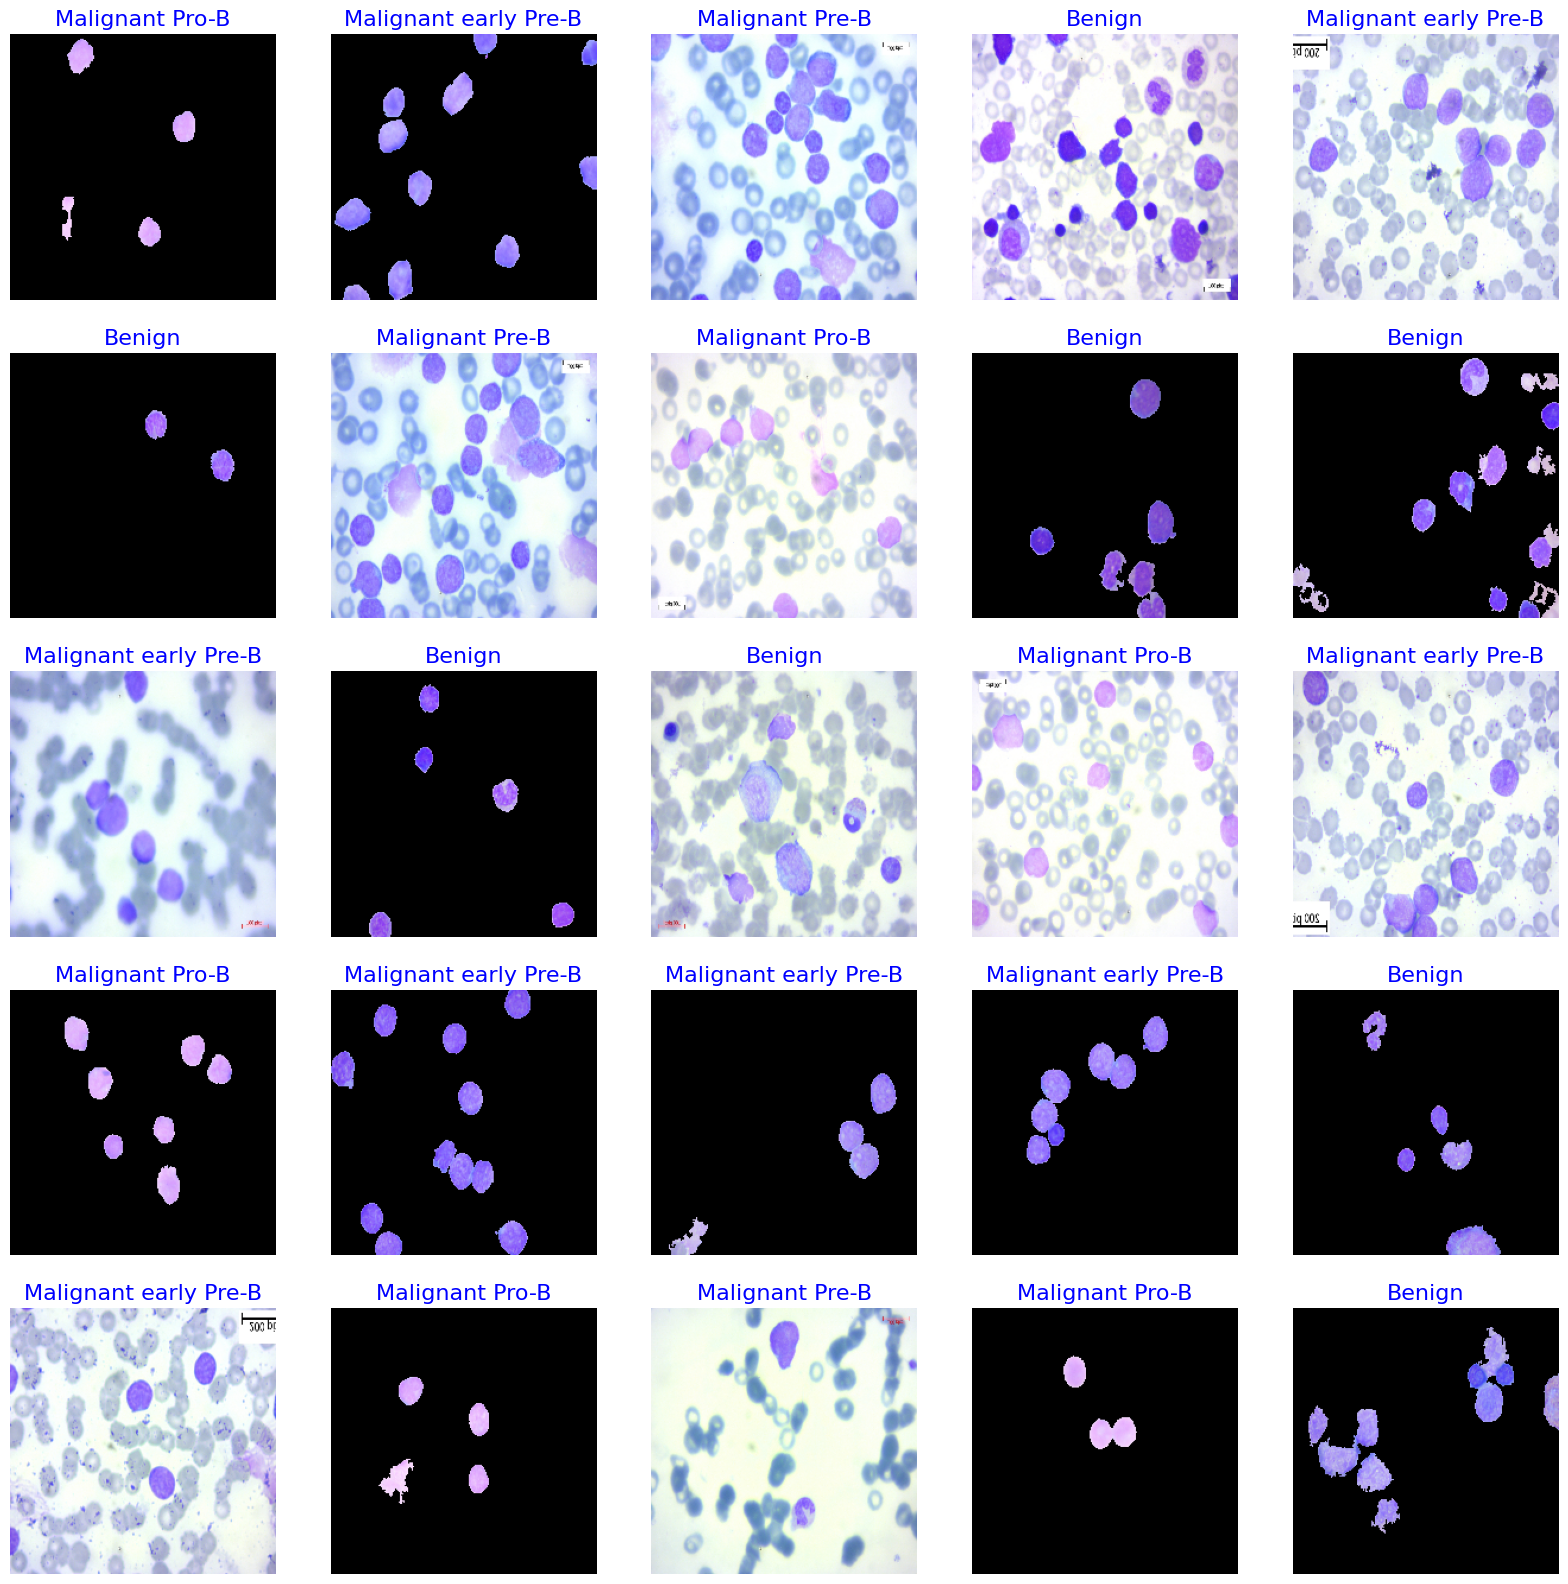

In [55]:
genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) #get sample batch from the generator
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

In [69]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [70]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoints'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights only when validation loss decreases
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only if the validation loss improves
                                                 monitor='val_loss',   # Monitor validation loss
                                                 mode='min',           # Save the weights when the metric is minimized
                                                 verbose=1)

# Training
history = model.fit(x=train_gen,
                    epochs=3,
                    validation_data=valid_gen,
                    steps_per_epoch=None,
                    workers=2,
                    callbacks=[cp_callback])


Epoch 1/3
165/165 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9229 
Epoch 1: val_loss improved from inf to 1.65299, saving model to /content/drive/MyDrive/checkpoints
165/165 [==============================] - 4142s 25s/step - loss: 0.2111 - accuracy: 0.9229 - val_loss: 1.6530 - val_accuracy: 0.2363
Epoch 2/3
137/165 [=======================>......] - ETA: 11:05 - loss: 0.0733 - accuracy: 0.9773

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))